# Executive Summary

The project seeks to use previous Citi Bike trip histories and customer information to predict each station's daily usage. This algorithm is to discover the high-demand station and analysis the daily usage to help the company better predict daily bike usage and reduce human resources at refilling stations. By creating a precise recommendation algorithm, we can ensure that customers can get a bike when needed and ultimately improve the customer experience.

# Problem Statement

1. What are the popular trips?
2. What influence daily bike share usage?
3. How to precisely forecast daily bike usage?

In [2]:
import pandas as pd
import numpy as np
import glob
import geopy.distance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from tbats import TBATS
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# Dataset Description

- started_at: YYYY-MM-DD HH:MM:SS
- ended_at: YYYY-MM-DD HH:MM:SS
- start_station_name: Station location
- start_station_id: Station ID
- end_station_name: Station location
- end_station_id: Station ID
- start_lat: Station latitude
- start_lng: Station longitude
- end_lat: Station latitude
- end_lng: Station longitude
- member_casual: member or casual ride (Casual = 24-hour pass or 3-day pass user;  Member = Annual Member)

Link: https://ride.citibikenyc.com/system-data

# Load The Dataset

There are two different types of datasets between 2015/09 - 2021/01 and 2020/02 - Now.
Before February 2021, the dataset contains lots of exciting features, but after February, we only have specific features to analyze. Thus, we decide to drop all the features that are not consistent and gather the rest of them into one dataset.


In [3]:
# read the csv files from different folder
def read_files():
    folder = glob.glob("JC-citibike-tripdata/202102-202207/*.csv")
    dfs = [pd.read_csv(f, sep=",", header=0) for f in folder]
    temp1 = pd.concat(dfs, ignore_index=True)
    temp1 = temp1.drop(["ride_id", "rideable_type"], axis=1)

    folder = glob.glob("JC-citibike-tripdata/201509-202101/*.csv")
    dfs = [pd.read_csv(f, sep=",", header=0, names=["trip_duration", "started_at", "ended_at", "start_station_id", "start_station_name", "start_lat", "start_lng",
                                                "end_station_id", "end_station_name", "end_lat", "end_lng", "bike_id", "member_casual", "birth_year", "gender"]) for f in folder]
    temp2 = pd.concat(dfs, ignore_index=True)
    temp2 = temp2.drop(["trip_duration", "bike_id", "birth_year", "gender"], axis=1)

    # combine two different type of history data
    return pd.concat([temp1, temp2], ignore_index=True)

In [4]:
file = read_files()
file.head()

,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,2021-02-03 23:11:28,2021-02-03 23:18:28,Hoboken Ave at Monmouth St,JC105,Christ Hospital,JC034,40.735208,-74.046964,40.734786,-74.050444,member
1,2021-02-27 16:34:05,2021-02-27 16:56:40,Newport Pkwy,JC008,Marin Light Rail,JC013,40.728744,-74.032108,40.714584,-74.042817,member
2,2021-02-26 23:16:04,2021-02-26 23:22:25,Journal Square,JC103,Baldwin at Montgomery,JC020,40.733670,-74.062500,40.723659,-74.064194,member
3,2021-02-24 16:51:50,2021-02-24 17:16:09,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,casual
4,2021-02-24 20:44:16,2021-02-24 20:44:46,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,member


In [5]:
# get the data size
file.shape

(2800634, 11)

# Data Cleaning

According to Citi Bike, these data has been pre-processed to remove the trips that are taken by staff or any trips that belows 60 seconds (potentially users try to re-dock or false starts). In this project, the prediction will base on the standard scenario, which means the anomalies events such as theft, broken docks, or broken bikes, will be removed.

### *Missing Values*

In [6]:
def remove_empty_row(df, cols):
    """
    :param df: a dataframe type of dataset
    :param cols: a list type of the columns
    :return: a dataframe with no spaces value in the columns, a dictionary with keys
    """
    result = df.copy()
    for col in cols:
        result = result.loc[~(result[col].str.fullmatch(r"\s*"))]
    return result

In [7]:
# get the feature's types
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800634 entries, 0 to 2800633
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   started_at          object 
 1   ended_at            object 
 2   start_station_name  object 
 3   start_station_id    object 
 4   end_station_name    object 
 5   end_station_id      object 
 6   start_lat           float64
 7   start_lng           float64
 8   end_lat             float64
 9   end_lng             float64
 10  member_casual       object 
dtypes: float64(4), object(7)
memory usage: 235.0+ MB


In [8]:
# check for null
file.isnull().sum()

started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name      5118
end_station_id        5118
start_lat                0
start_lng                0
end_lat               3475
end_lng               3475
member_casual          497
dtype: int64

In [8]:
# find out the missing value (spaces) percentage in each column
check_space = (file.apply(lambda row: row.str.fullmatch(r"\s*"), axis=1).sum() * 100 / len(file)).sort_values(ascending=False).reset_index(name="missing")

print(check_space)

                 index missing
0           started_at     0.0
1             ended_at     0.0
2   start_station_name     0.0
3     start_station_id     0.0
4     end_station_name     0.0
5       end_station_id     0.0
6            start_lat     0.0
7            start_lng     0.0
8              end_lat     0.0
9              end_lng     0.0
10       member_casual     0.0


In [9]:
# Since the dataset contains the situation that some rider didn't return the bike, but the prediction will only base on the standard scenario. Thus, we will remove those emtpy rows without station id.
file = file.loc[file["end_station_id"].notnull()]
file = file.loc[file["member_casual"].notnull()]

# Data Preprocessing

### *Update Variables*

Some values are different between the old and recent datasets. Thus, this step is to make sure the "member_casual" has a consistent variable.

In [10]:
file.loc[file.member_casual == "Subscriber", "member_casual"] = "member"
file.loc[file.member_casual == "Customer", "member_casual"] = "casual"

### *New Variables*

We will analyze the time frame and the gis' information to get the duration and distance of each trip.

In [11]:
# change time from string to datetime type
file["started_at"] = pd.to_datetime(file["started_at"], format="%Y-%m-%d %H:%M:%S")
file["ended_at"] = pd.to_datetime(file["ended_at"], format="%Y-%m-%d %H:%M:%S")

# get the total duration of each ride
file["ride_duration_sec"] = (file.ended_at - file.started_at).dt.total_seconds()
# get the total distance of each ride
file["ride_distance_m"] = file.apply\
    (lambda row: geopy.distance.geodesic((row.start_lat, row.start_lng), (row.end_lat, row.end_lng)).meters, axis=1)

# separate the date and hours and drop the original columns
file["started_time"] = pd.cut(pd.to_datetime(file["started_at"]).dt.hour, [00, 12, 24], labels=["Morning", "Evening"], right=False, include_lowest=True)
file["ended_time"] = pd.cut(pd.to_datetime(file["ended_at"]).dt.hour, [00, 12, 24], labels=["Morning", "Evening"], right=False, include_lowest=True)
file["started_date"] = pd.to_datetime([t.date() for t in file["started_at"]], format="%Y-%m-%d")
file["ended_date"] = pd.to_datetime([t.date() for t in file["ended_at"]], format="%Y-%m-%d")

file = file.drop(["started_at", "ended_at"], axis=1)

file.head()

,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_sec,ride_distance_m,started_time,ended_time,started_date,ended_date
0,Hoboken Ave at Monmouth St,JC105,Christ Hospital,JC034,40.735208,-74.046964,40.734786,-74.050444,member,420.0,297.671926,Evening,Evening,2021-02-03,2021-02-03
1,Newport Pkwy,JC008,Marin Light Rail,JC013,40.728744,-74.032108,40.714584,-74.042817,member,1355.0,1814.171782,Evening,Evening,2021-02-27,2021-02-27
2,Journal Square,JC103,Baldwin at Montgomery,JC020,40.733670,-74.062500,40.723659,-74.064194,member,381.0,1120.895598,Evening,Evening,2021-02-26,2021-02-26
3,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,casual,1459.0,0.076241,Evening,Evening,2021-02-24,2021-02-24
4,Hoboken Ave at Monmouth St,JC105,Hoboken Ave at Monmouth St,JC105,40.735208,-74.046963,40.735208,-74.046964,member,30.0,0.076241,Evening,Evening,2021-02-24,2021-02-24


### *New Dataset*

Since the original dataset only contains trip information, we will transform them into a time series dataset for further analysis.

In [12]:
trips_station_data = file.groupby(["start_station_name","end_station_name"]).size().reset_index(name="number_of_trips").sort_values(by="number_of_trips", ascending=False)

trips_station_data.head()

,start_station_name,end_station_name,number_of_trips
4002,Hamilton Park,Grove St PATH,37256
3876,Grove St PATH,Hamilton Park,27820
1777,Brunswick St,Grove St PATH,23326
6331,McGinley Square,Sip Ave,23281
5509,Liberty Light Rail,Liberty Light Rail,21117


Although the dataset didn't contain null value, we might still miss few days' data. Therefore, we decide to fill the missing datetime with the previous day's values.


In [13]:
# create a daily rides time series with timezone
trips_daily_data = file.groupby(["started_date", "member_casual", "started_time"])["started_time"].agg("count").unstack(fill_value=0).unstack(fill_value=0)
trips_daily_data["total_rides"] = file.groupby(["started_date"]).size()

# check the date consistency
# pd.date_range(start=ride_data.index.min(), end=ride_data.index.max()).difference(ride_data.index)

# fill missing datetime with previous day's values
trips_daily_data = trips_daily_data.reindex(pd.date_range(file["started_date"].min(),
                                                        file["started_date"].max())).reset_index().rename(columns={"index": "started_date"})
trips_daily_data = trips_daily_data.groupby(trips_daily_data["started_date"].dt.time).ffill()
trips_daily_data.set_index("started_date", inplace=True)

trips_daily_data.head()

started_time  Morning        Evening        total_rides
member_casual  casual member  casual member            
started_date                                           
2015-09-21        0.0    0.0    40.0  227.0       267.0
2015-09-22       17.0  166.0    67.0  315.0       565.0
2015-09-23       23.0  203.0    78.0  375.0       679.0
2015-09-24       23.0  208.0    72.0  361.0       664.0
2015-09-25       24.0  206.0    73.0  370.0       673.0

In [ ]:
"""
# create a daily rides time series with membership
trips_user_data = file.groupby(["started_date", "member_casual"]).size().unstack(fill_value=0)
trips_user_data["total_rides"] = file.groupby(["started_date"]).size()

# fill missing datetime with previous day's values
trips_user_data = trips_user_data.reindex(pd.date_range(file["started_date"].min(),
                                                        file["started_date"].max())).reset_index().rename(columns={"index": "started_date"})
trips_user_data = trips_user_data.groupby(trips_user_data["started_date"].dt.time).ffill()
trips_user_data.set_index("started_date", inplace=True)

trips_user_data.head()
"""

In [ ]:
"""
# create a monthly rides time series
trips_monthly_data = trips_daily_data.groupby(trips_daily_data.index.strftime("%Y-%m"))["total_rides"].agg("sum").reset_index(name="total_rides")
trips_monthly_data = trips_monthly_data.rename(columns={"started_date": "started_month"})
trips_monthly_data.set_index("started_month", inplace=True)

trips_monthly_data
"""

### *Normalize*

In [15]:
def normalization(df, scaler):
    """
    :param df:
    :param scaler:
    :return:
    """
    result = df.copy()
    if scaler == "z-score":
        return pd.DataFrame(StandardScaler().fit_transform(result))
    if scaler == "min-max":
        return pd.DataFrame(MinMaxScaler().fit_transform(result))

In [16]:
trips_daily_nor = normalization(trips_daily_data, "min-max").assign(label=trips_daily_data.index)
trips_daily_nor.columns = trips_daily_data.columns.to_list() +  ["started_date"]
trips_daily_nor.set_index("started_date", inplace=True)

trips_daily_nor.head()

,"(Morning, casual)","(Morning, member)","(Evening, casual)","(Evening, member)","(total_rides, )"
started_date,,,,,
2015-09-21,0.000000,0.000000,0.017994,0.134082,0.059495
2015-09-22,0.028523,0.198565,0.030139,0.186060,0.126146
2015-09-23,0.038591,0.242823,0.035088,0.221500,0.151644
2015-09-24,0.038591,0.248804,0.032389,0.213231,0.148289
2015-09-25,0.040268,0.246411,0.032839,0.218547,0.150302


### *Numericalize*

In [15]:
def numericalize(df):
    """
    :param df: a dataframe
    :return: a dataframe with no object type
    """
    result = df.copy()
    key = {}
    le = preprocessing.LabelEncoder()
    for col in result:
        if result.dtypes[col] == np.object0 or result[col].dtype.name == "category":
            le.fit(result[col].astype(str))
            result[col] = le.transform(result[col].astype(str))
            key[col] = le.inverse_transform(np.unique(result[col]))
    return result, key

In [16]:
# numericalize original dataset
raw_data, raw_data_key = numericalize(file)

raw_data.head()

,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_sec,ride_distance_m,started_time,ended_time,started_date,ended_date
0,52,143,111,585,40.735208,-74.046964,40.734786,-74.050444,1,420.0,297.671926,0,0,2021-02-03,2021-02-03
1,80,98,277,575,40.728744,-74.032108,40.714584,-74.042817,1,1355.0,1814.171782,0,0,2021-02-27,2021-02-27
2,61,141,55,579,40.733670,-74.062500,40.723659,-74.064194,1,381.0,1120.895598,0,0,2021-02-26,2021-02-26
3,52,143,225,617,40.735208,-74.046963,40.735208,-74.046964,0,1459.0,0.076241,0,0,2021-02-24,2021-02-24
4,52,143,225,617,40.735208,-74.046963,40.735208,-74.046964,1,30.0,0.076241,0,0,2021-02-24,2021-02-24


# Data Visualization

### *Columns Distribution*

In [17]:
def graph_frequency_numeric(df):
    """
    :param df: a dataframe only contains numeric value
    :return: a combine bar chart
    """
    row = len(df.columns)
    fig, axes = plt.subplots(figsize=(18, 36))
    for col in range(row):
        ax = plt.subplot(row, 2, col + 1)
        df[df.columns[col]].hist()
        ax.set_title(df.columns[col] + " (log)")
        ax.set_yscale('log')
    fig.tight_layout()
    plt.show()


def graph_frequency_string(df):
    """
    :param df: dataframe only contains object value
    :return: a bar chart
    """
    row = len(df.columns)
    fig, axes = plt.subplots(figsize=(27, 15))
    # Set general font size
    plt.rcParams["font.size"] = "12"
    for col in range(row):
        # get a series with the value count in each column
        count = df[df.columns[col]].value_counts()
        # transform series into dataframe
        data = count.reset_index(name="total").sort_values(by=["total"], ascending=True)
        # the label locations
        index = range(len(data[data.columns[0]]))
        ax = plt.subplot(row, 2, col + 1)
        ax.set_title(df.columns[col], fontsize=18)
        ax.set_ylabel("Frequency", labelpad=9, fontsize=12)
        # if the size of features is more than 5, only show the top 5 results on the chart.
        if index[-1] > 10:
            index = range(10)
            data = data.tail(10)
            ax.set_yticks(index, list(data[data.columns[0]]), rotation=0)
            ax.bar_label(plt.barh(index, data[data.columns[1]], align="edge"), fontsize=12, padding=6)
        else:
            ax.set_yticks(index, list(data[data.columns[0]]), rotation=0)
            ax.bar_label(plt.barh(index, data[data.columns[1]], align="edge"), fontsize=12, padding=6)
    fig.tight_layout()
    plt.show()

In [18]:
# basic description
raw_data.describe()

,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_duration_sec,ride_distance_m,started_time,ended_time
count,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06,2.795019e+06
mean,5.575294e+01,5.387703e+01,2.308450e+02,2.817125e+02,4.072587e+01,-7.404420e+01,4.071413e+01,-7.402293e+01,7.743328e-01,9.579698e+02,3.503446e+03,3.299344e-01,3.231456e-01
std,2.494543e+01,4.260338e+01,9.848138e+01,2.363648e+02,1.038767e-02,1.186045e-02,6.833638e-01,1.242345e+00,4.180210e-01,2.190174e+04,1.454645e+05,4.701891e-01,4.676779e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.069264e+01,-7.409694e+01,0.000000e+00,-7.409694e+01,0.000000e+00,-3.396000e+03,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.900000e+01,1.900000e+01,1.850000e+02,7.900000e+01,4.071849e+01,-7.404997e+01,4.071836e+01,-7.404964e+01,1.000000e+00,2.600000e+02,5.846089e+02,0.000000e+00,0.000000e+00
50%,5.500000e+01,4.400000e+01,2.260000e+02,1.170000e+02,4.072418e+01,-7.404312e+01,4.072333e+01,-7.404312e+01,1.000000e+00,4.212180e+02,8.945897e+02,0.000000e+00,0.000000e+00
75%,7.900000e+01,9.200000e+01,2.930000e+02,5.650000e+02,4.073090e+01,-7.403423e+01,4.073074e+01,-7.403376e+01,1.000000e+00,7.590000e+02,1.416517e+03,1.000000e+00,1.000000e+00
max,9.600000e+01,1.480000e+02,4.790000e+02,6.240000e+02,4.075470e+01,-7.402385e+01,4.087241e+01,0.000000e+00,1.000000e+00,2.026021e+07,8.673984e+06,1.000000e+00,1.000000e+00


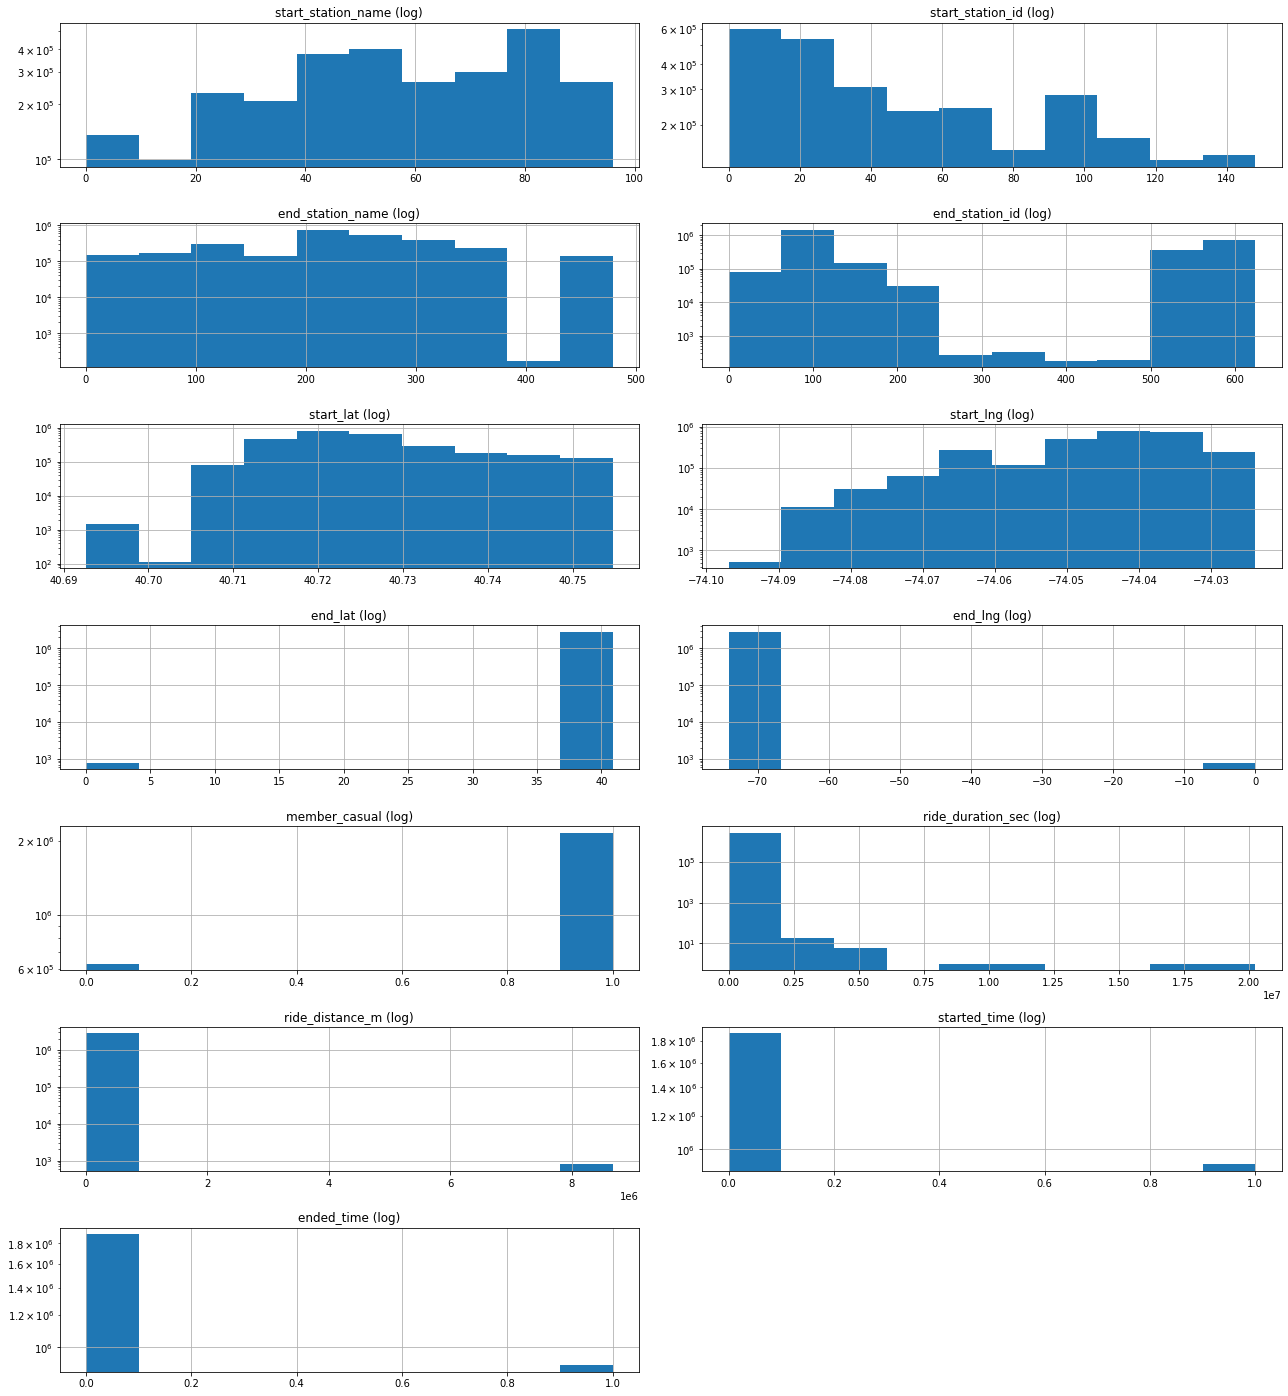

In [19]:
# other methods will check the time-based data; thus, we will skip this step
graph_frequency_numeric(raw_data.iloc[:, :-2])

### *Correlation Detection*

In [17]:
trips_daily_nor.corr(method="pearson").style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,"('Morning', 'casual')","('Morning', 'member')","('Evening', 'casual')","('Evening', 'member')","('total_rides', '')"
"('Morning', 'casual')",1.00,0.38,0.94,0.67,0.85
"('Morning', 'member')",0.38,1.00,0.34,0.84,0.75
"('Evening', 'casual')",0.94,0.34,1.00,0.69,0.87
"('Evening', 'member')",0.67,0.84,0.69,1.00,0.95
"('total_rides', '')",0.85,0.75,0.87,0.95,1.00


# Interesting Highlight

### Part 1: Most of the bike is for fulfilling short trip missions

Based on the 50% quartile, most Citi Bike riders who own memberships and only ride 800 meters per trip. It could mean the users most likely use the bike to perform some quick task which is not close enough to walk to, but also not too far away, e.g., a round trip between house and transportation.

In [25]:
file["ride_distance_m"].loc[file["member_casual"] == "member"].describe()

count   2164275.00
mean       3768.40
std      153997.06
min           0.00
25%         600.10
50%         886.17
75%        1378.23
max     8673984.48
Name: ride_distance_m, dtype: float64

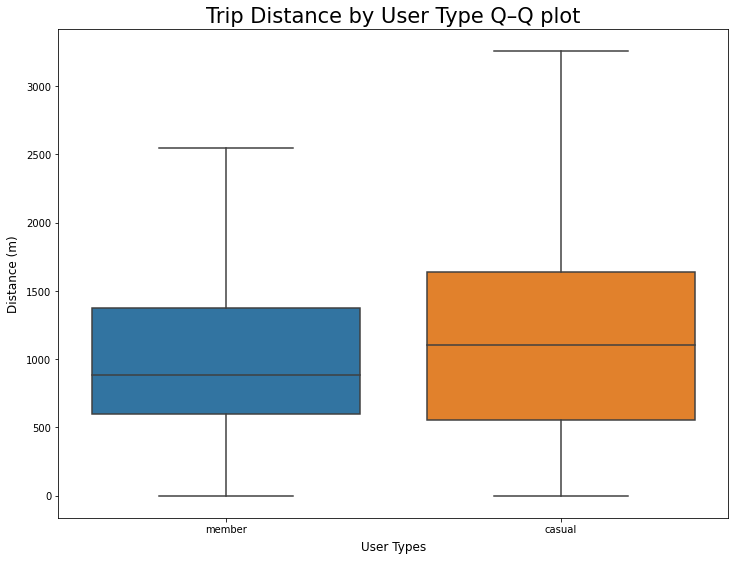

In [41]:
# get the overall trip distance information
plt.figure(figsize=(12, 9))
sns.boxplot(x=file.member_casual, y=file.ride_distance_m, showfliers = False)
plt.ylabel("Distance (m)", labelpad=6, fontsize=12)
plt.xlabel("User Types", labelpad=6, fontsize=12)
plt.title("Trip Distance by User Type Q–Q plot", fontsize=21)
plt.show()

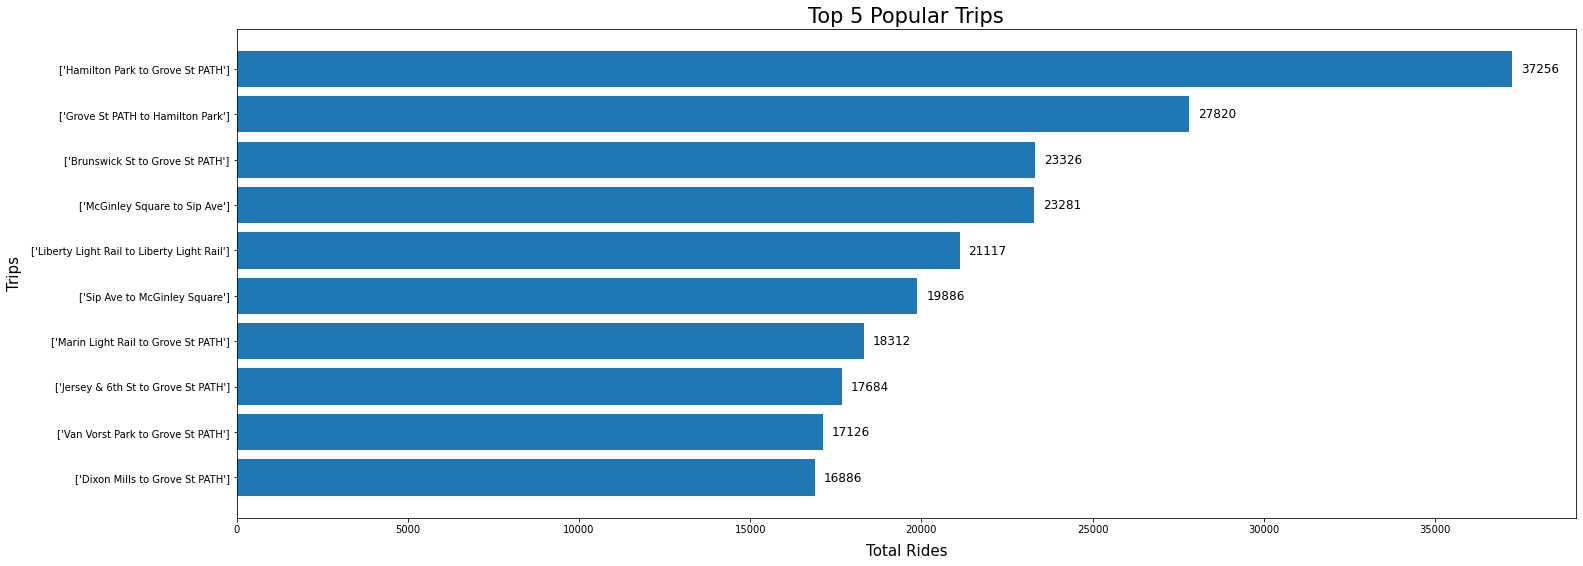

In [34]:
plt.figure(figsize=(24, 9))
plt.bar_label(plt.barh(range(10), trips_station_data.number_of_trips[:10], align="center"), fontsize=12, padding=9)
plt.gca().invert_yaxis()
plt.yticks(range(10), labels=pd.DataFrame(trips_station_data.start_station_name + " to " + trips_station_data.end_station_name)[:10].values)
plt.xlabel("Total Rides", labelpad=9, fontsize=15)
plt.ylabel("Trips", labelpad=9, fontsize=15)
plt.title("Top 10 Popular Trips", fontsize=21)
plt.show()

One of the things to be aware of when we read the charts in EDA is human bias. In this chart, we might think Groove St Path station had so many trips let's focus on filling more bikes into this hot spot. However, the truth is the opposite because this hot spot collects more bikes than renting out. Therefore, consistently refilling the stations that go to this hot spot is the key to ensuring riders can get a bike when needed.


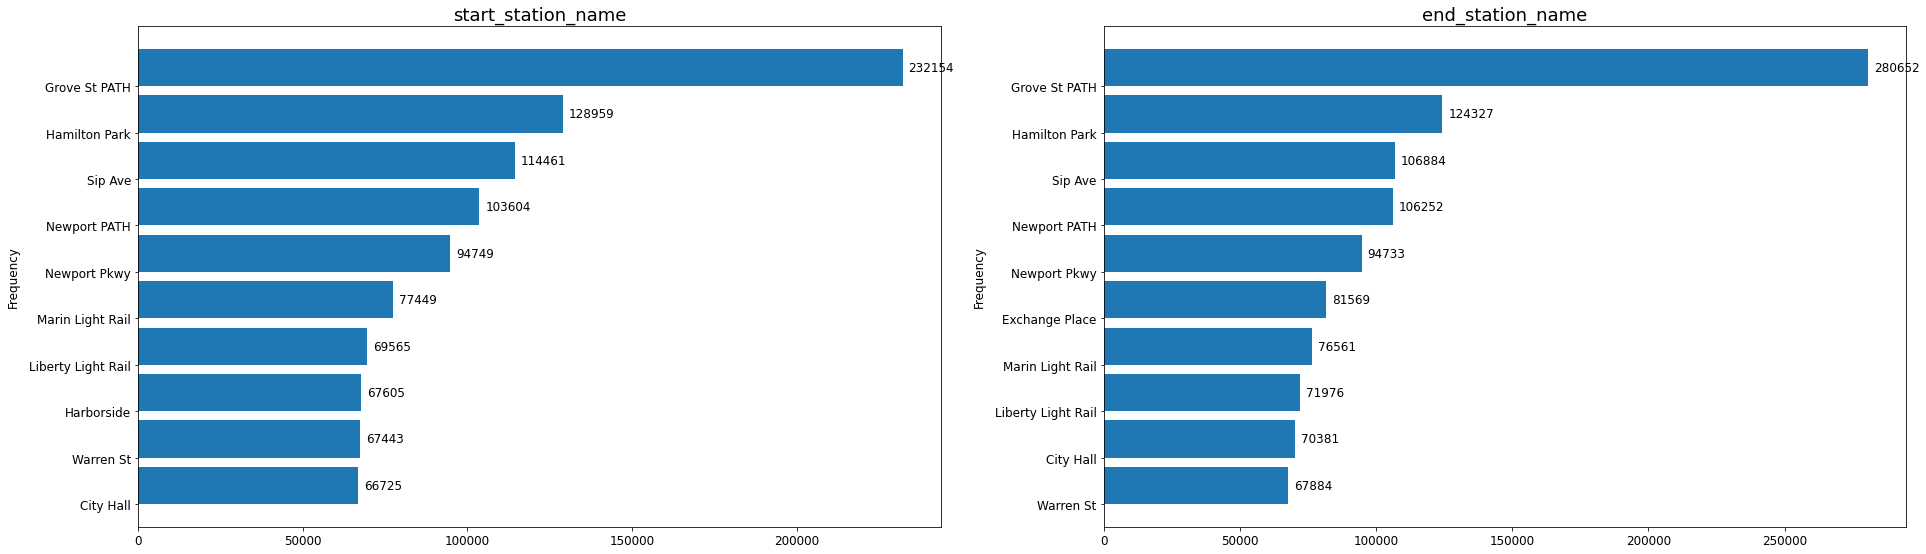

In [78]:
graph_frequency_string(file[["start_station_name", "end_station_name"]])

### Part 2: Non-subscribers are more willing to ride longer time than annual subscribers

This highlight is an interesting phenomenon, but unfortunately, we do not have more data to do a deeper analysis. One of the assumptions is that the casual user tends to use the bike for a long one-way trip, e.g., exploring the city, unlike subscribers who tend to use the bike for shorter round-trips, e.g., from house to school.


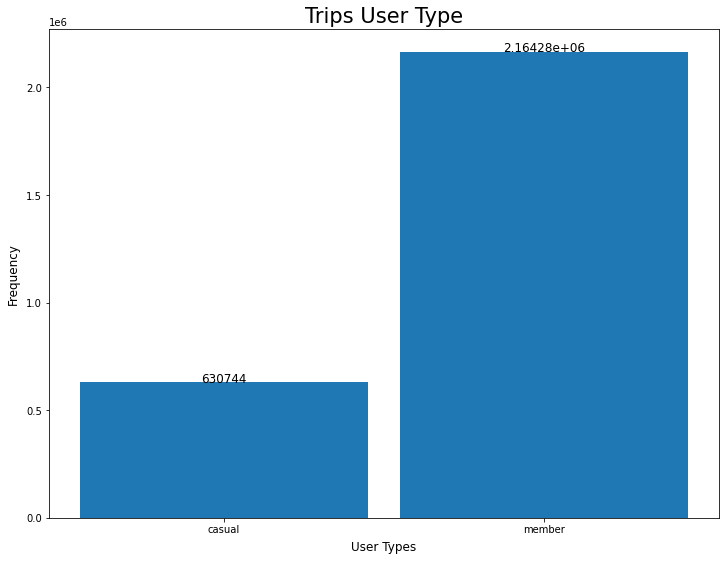

In [35]:
#
plt.figure(figsize=(12, 9))
plt.bar_label(plt.bar(file.member_casual.value_counts().sort_index().index, file.member_casual.value_counts().sort_index(), align="center", width=0.9), fontsize=12, padding=-3)
plt.ylabel("Frequency", labelpad=6, fontsize=12)
plt.xlabel("User Types", labelpad=6, fontsize=12)
plt.title("Trips User Type", fontsize=21)
plt.show()

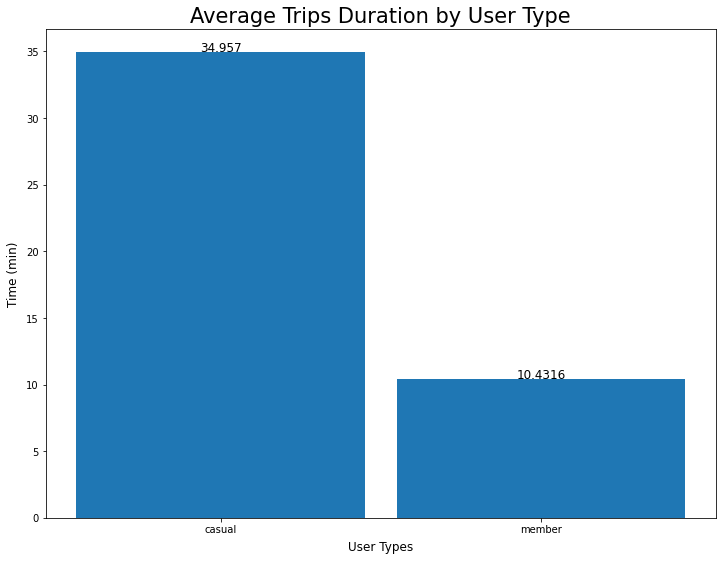

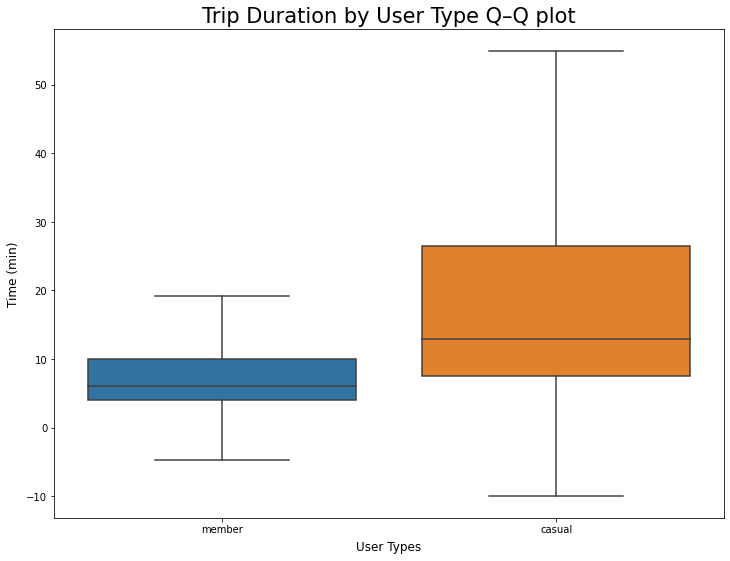

In [37]:
# get the average minutes trip duration information
trip_df = file.groupby(["member_casual"])["ride_duration_sec"].agg("mean").reset_index(name="avg_min_duration")
trip_df["avg_min_duration"] = trip_df["avg_min_duration"] / 60

plt.figure(figsize=(12, 9))
plt.bar_label(plt.bar(trip_df.member_casual, trip_df.avg_min_duration, align="center", width=0.9), fontsize=12, padding=-3)
plt.ylabel("Time (min)", labelpad=6, fontsize=12)
plt.xlabel("User Types", labelpad=6, fontsize=12)
plt.title("Average Trips Duration by User Type", fontsize=21)
plt.show()

# get the overall trip duration information in minutes
plt.figure(figsize=(12, 9))
sns.boxplot(x=file.member_casual, y=file.ride_duration_sec.div(60).round(2), showfliers = False)
plt.ylabel("Time (min)", labelpad=6, fontsize=12)
plt.xlabel("User Types", labelpad=6, fontsize=12)
plt.title("Trip Duration by User Type Q–Q plot", fontsize=21)
plt.show()

### Part 3: Most riders use the bike share in afternoon
Another interesting phenomenon is that no matter whether the member or casual riders, they all tend to use the bikes in the evening. Therefore, the best time for the company to refill the bikes is before 12 PM.

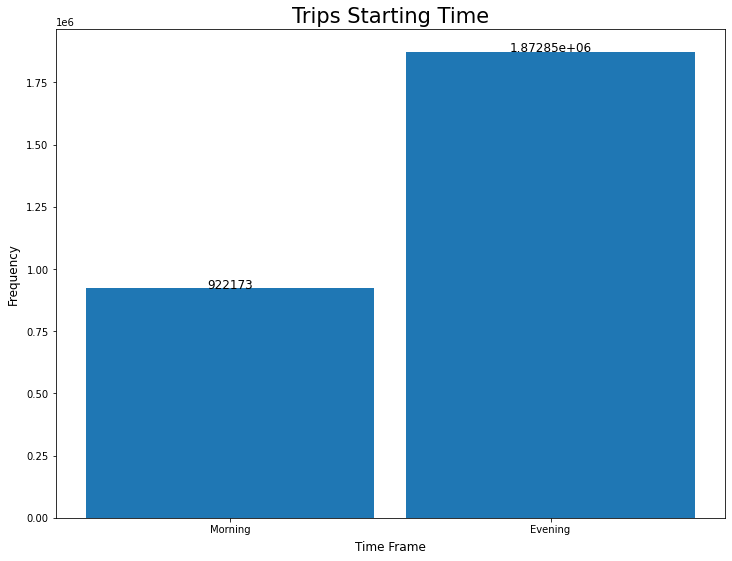

In [46]:
plt.figure(figsize=(12, 9))
plt.bar_label(plt.bar(file.started_time.value_counts().sort_index().index, file.started_time.value_counts().sort_index(), align="center", width=0.9), fontsize=12, padding=-3)
plt.ylabel("Frequency", labelpad=6, fontsize=12)
plt.xlabel("Time Frame", labelpad=6, fontsize=12)
plt.title("Trips Starting Time", fontsize=21)
plt.show()

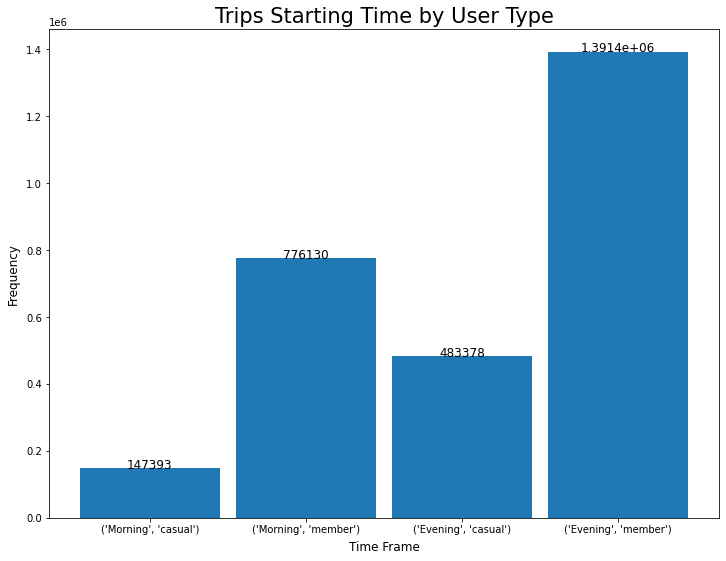

In [66]:
# get the trips information by user type and time frame
plt.figure(figsize=(12, 9))
plt.bar_label(plt.bar([str(x) for x in trips_daily_data.sum().index][:-1], trips_daily_data.sum()[:-1], align="center", width=0.9), fontsize=12, padding=-3)
plt.ylabel("Frequency", labelpad=6, fontsize=12)
plt.xlabel("Time Frame", labelpad=6, fontsize=12)
plt.title("Trips Starting Time by User Type", fontsize=21)
plt.show()

### Part 4: All types of user tends to use more bike in Summer than Winter

Based on the time series dataset, the share bike industry has a relatively seasonal pattern. After April, more users start using, and the usage will quickly reduce after September.

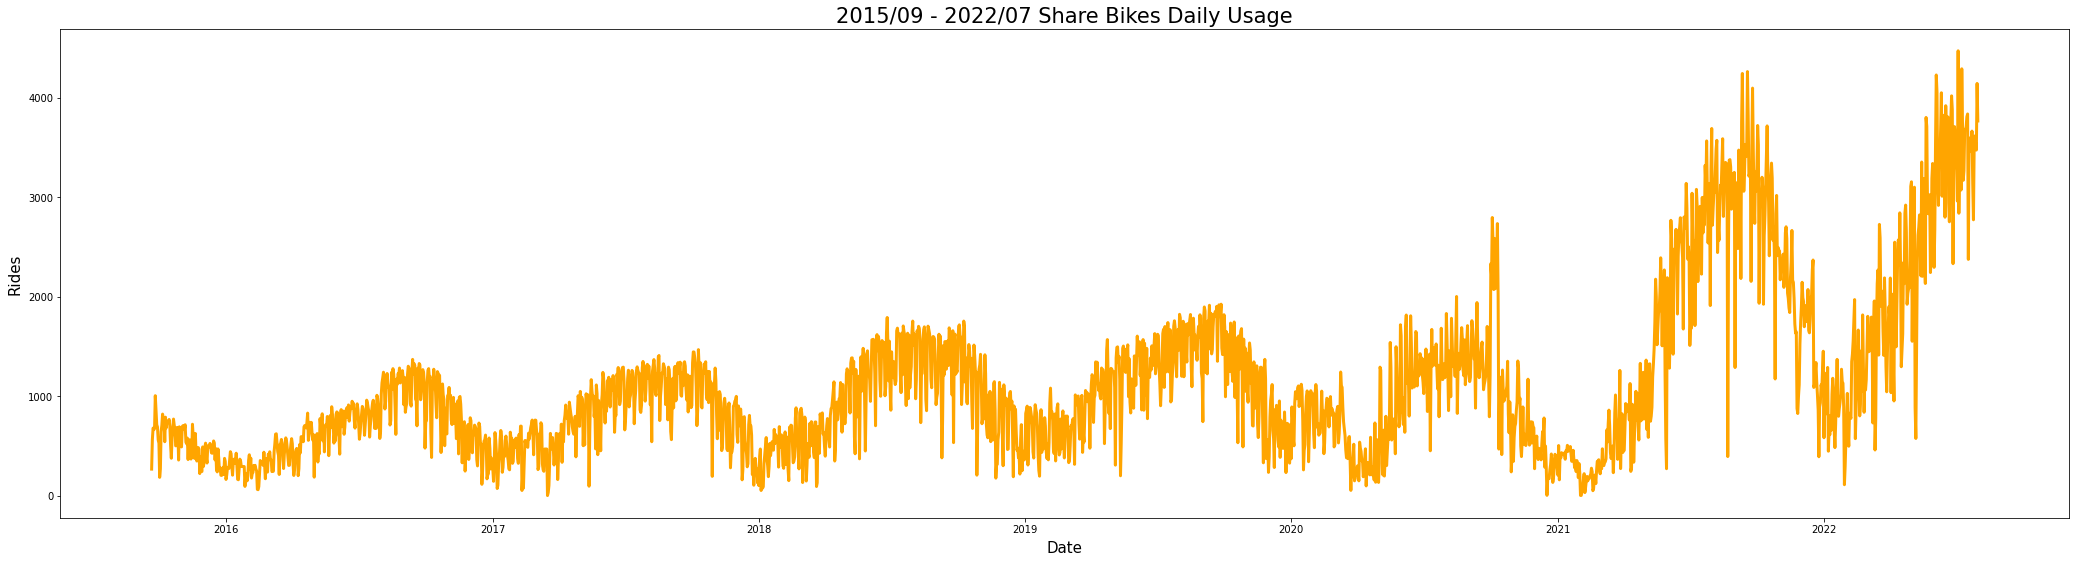

In [47]:
plt.figure(figsize=(36, 9))
plt.plot(trips_daily_data.total_rides, linewidth=3, color="orange")
plt.ylabel("Rides", labelpad=6, fontsize=15)
plt.xlabel("Date", labelpad=6, fontsize=15)
plt.title("2015/09 - 2022/07 Share Bikes Daily Usage", fontsize=21)
plt.show()

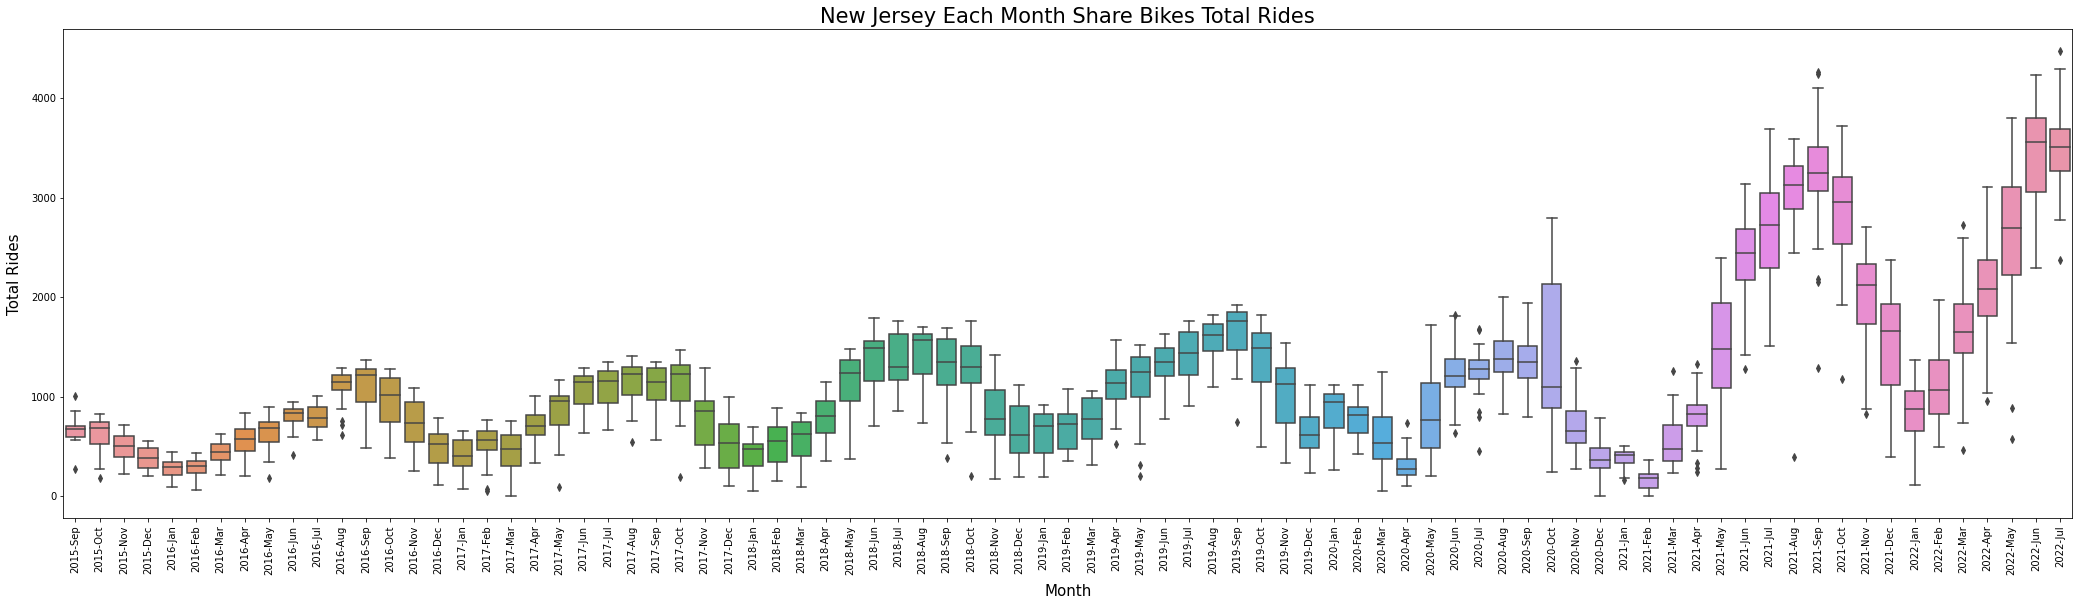

In [48]:
ts_fig, ts_ax = plt.subplots(figsize=(36, 9))
sns.boxplot(x=trips_daily_data.index.strftime("%Y-%b"), y=trips_daily_data.total_rides, ax=ts_ax)
ts_ax.set_xlabel("Month", labelpad=9, fontsize=15)
ts_ax.set_ylabel("Total Rides", labelpad=9, fontsize=15)
ts_ax.set_xticklabels(ts_ax.get_xticklabels(), rotation=90)
ts_ax.set_title("New Jersey Each Month Share Bikes Total Rides", fontsize=21)
plt.show()

# Time Series Prediction

### *Training And Testing Set*

Due to the model limitations, the model only predicts the next 21 days of total share bike rides daily usage.

In [ ]:
"""
def daily_time_series_split(df, train_percent, d):
    start = df.index.min()
    end = df.index.max()
    time_between = end - start
    train_cutoff = start + train_percent * time_between

    training_set = df[df.index <= train_cutoff]
    if d > 0:
        testing_set = df[df.index > train_cutoff][:-d]
    else:
        testing_set = df[df.index > train_cutoff]
    return training_set, testing_set, start, end, train_cutoff

train, test, start_date, end_date, cutoff_date = daily_time_series_split(ride_daily_nor, 0.992, 0) # 0.988 = month 0.9945 = two weeks
"""

In [67]:
def time_series_split(df, train_percent):
    train_size = int(len(df) * train_percent)
    predictor_train, target_train = pd.DataFrame(df.iloc[:train_size, :-1]), pd.DataFrame(df.iloc[:train_size, -1])
    predictor_test, target_test = pd.DataFrame(df.iloc[train_size:, :-1]), pd.DataFrame(df.iloc[train_size:, -1])
    return predictor_train, predictor_test, target_train, target_test

In [68]:
X_train, X_test, y_train, y_test = time_series_split(trips_daily_nor, 0.992)

### *Time Series Decomposition*

To better understand the time series data, we will decompose the data into level, trend, seasonality, and random noise factors.
Additive model = Trend + Seasonality + Random Noise

In [69]:
def decompose(df, period):
    """
    :param df:
    :param period: daily=365,
    :return:
    """
    decomposition = seasonal_decompose(df, model="additive", period=period)

    fig, axs = plt.subplots(4, 1, figsize=(18, 18))
    # original time series
    axs[0].plot(decomposition.observed)
    axs[0].set_title("Original Series", size=15)
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))
    # trend
    axs[1].plot(decomposition.trend)
    axs[1].set_title("Trend", size=15)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    # seasonal
    axs[2].plot(decomposition.seasonal)
    axs[2].set_title("Seasonal", size=15)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(7))
    # residual
    axs[3].plot(decomposition.resid)
    axs[3].set_title("Residual", size=15)
    axs[3].xaxis.set_major_locator(plt.MaxNLocator(7))
    plt.show()

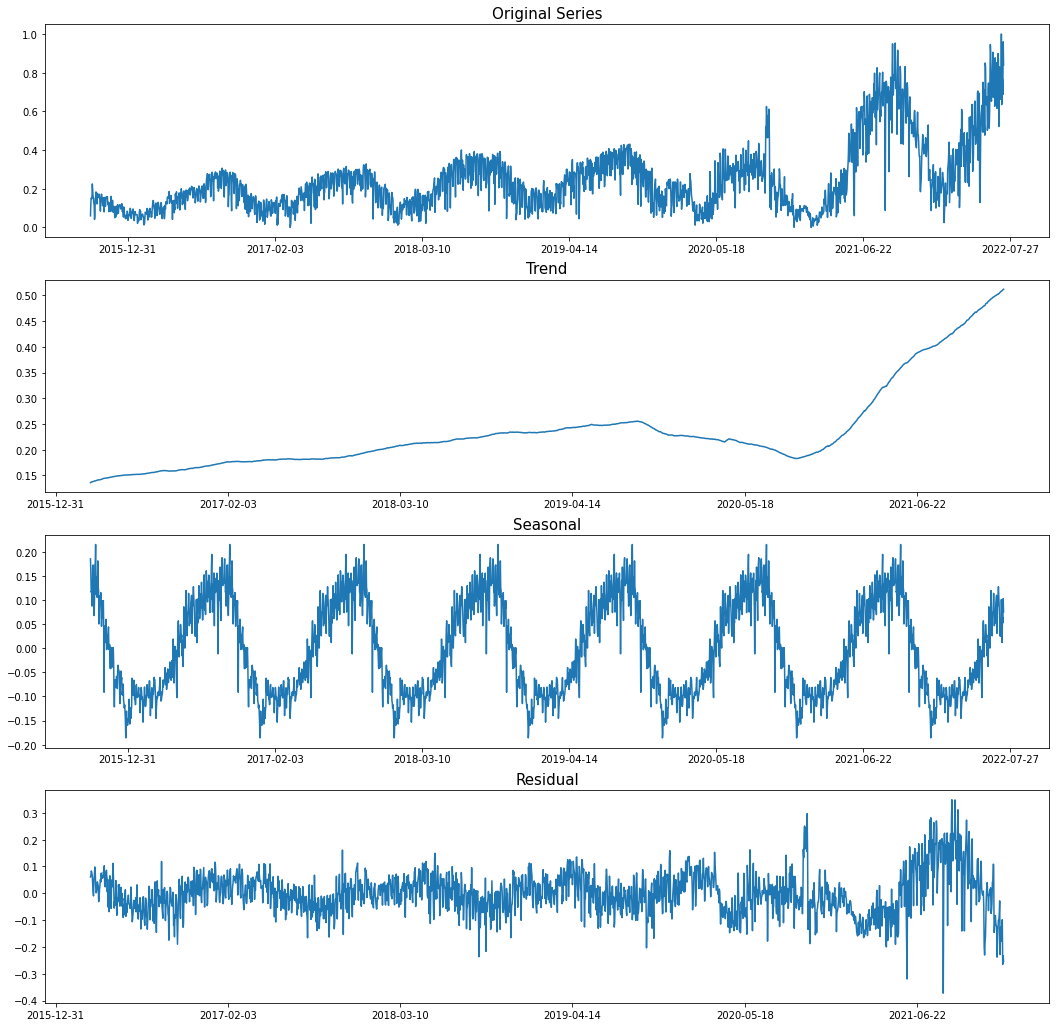

In [70]:
decompose(y_train, 365)

### *Stationary Detection*

The stationary involves the predictabilities of the time series data. The strict stationery describes the entire probability distribution as timeshift-invariant, and the weak stationary informs the mean and covariance are timeshift-invariant, which means the t moment of the value is highly dependent on its history.

In [71]:
def stationary(df):
    ori_df = df # original time series
    fir_df = df.diff().dropna() # first difference time series
    sec_df = df.diff().diff().dropna() # second difference time series
    stationary_test = None

    fig, axs = plt.subplots(3, 3, figsize=(21, 9))
    for i in range(3):
        if i == 0:
            print("Original Time Series")
            stationary_test = adfuller(ori_df)
            axs[i, 0].plot(ori_df)
            axs[i, 0].set_title("Original Time Series")
        elif i == 1:
            print("First Order Differencing")
            stationary_test = adfuller(fir_df)
            axs[i, 0].plot(fir_df)
            axs[i, 0].set_title("First Order Differencing")
        elif i == 2:
            print("Second Order Differencing")
            stationary_test = adfuller(sec_df)
            axs[i, 0].plot(sec_df)
            axs[i, 0].set_title("Second Order Differencing")
        plot_acf(df, ax=axs[i, 1])
        plot_pacf(df, ax=axs[i, 2])

        print("ADF Statistic: %f" %stationary_test[0])
        print("p-value: %f\n" %stationary_test[1])

    # hide x and tick labels
    for ax in axs.flat:
        ax.label_outer()
    plt.show()

Original Time Series
ADF Statistic: -0.823052
p-value: 0.812257

First Order Differencing
ADF Statistic: -13.045499
p-value: 0.000000

Second Order Differencing
ADF Statistic: -19.234634
p-value: 0.000000



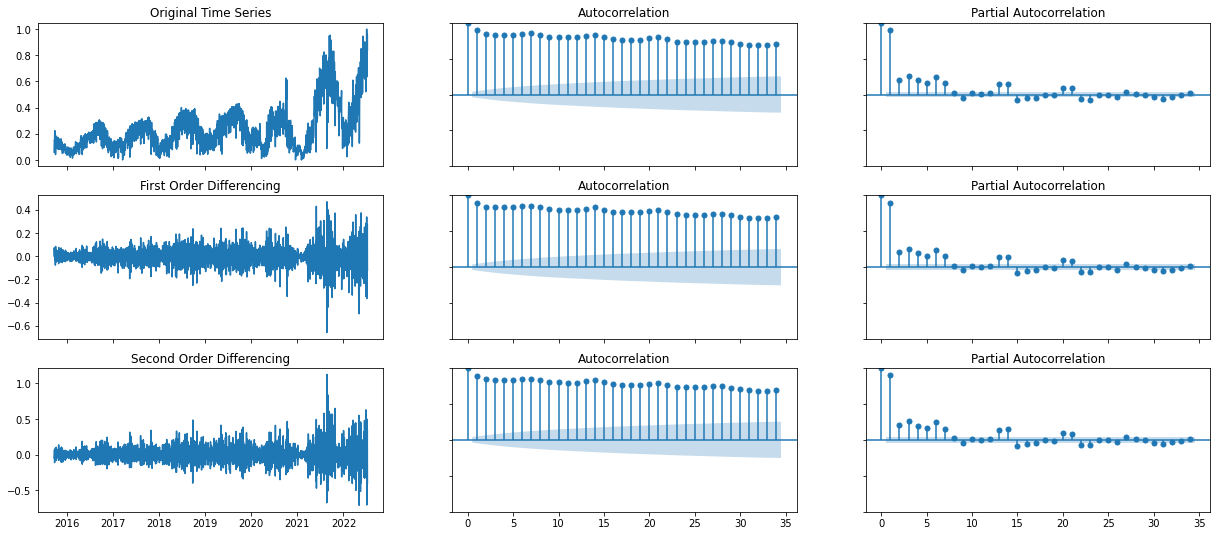

In [72]:
stationary(y_train)

After stationary detection, the original time series is not stable. First, the ADF statistic is still close to 0, but we know that the more negative means the time series are more likely to be stationary. Second, the p-value is much greater than 0.05, and we only can reject the null hypothesis (non-stationary) when the p-value is small. Therefore, we decided to use the first differencing for the following model.

Moreover, in the PACF plot, there are significant spikes at lag-1 and lag-2, which means the lag-1 and lag-2 autocorrelation can effectively explain all the higher-order autocorrelation.


*For more information: https://www.youtube.com/watch?v=bP1fbXd_XSk*

### *ARIMA Model*

In [104]:
# m refers to the number of periods in each season. daily-7, weekly-52, monthly-12, quarterly-4, annually-1
arima_param = auto_arima(y_train, m=7, start_p=1, d=1, start_q=1, max_p=5, max_q=5, trace=True, seasonal=False)

C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (7) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6339.312, Time=1.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5597.261, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5767.806, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6157.623, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5599.221, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6379.841, Time=1.96 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5973.469, Time=0.42 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6384.471, Time=2.57 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6094.720, Time=0.28 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-6392.361, Time=2.80 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-6174.636, Time=0.94 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-6422.413, Time=4.12 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-6342.522, Time=0.64 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-6410.116, Time=3.43 sec
 ARIMA(4,1,2)(0,0,0

In [105]:
# using p values to confirm the residual distribution and the correlation
arima_param.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2485
Model:               SARIMAX(5, 1, 1)   Log Likelihood                3218.892
Date:                Sun, 14 Aug 2022   AIC                          -6423.784
Time:                        18:38:13   BIC                          -6383.060
Sample:                             0   HQIC                         -6408.994
                               - 2485                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0063      0.034      0.182      0.855      -0.061       0.074
ar.L2         -0.2869      0.022    -13.068      0.000      -0.330      -0.244
ar.L3         -0.1976      0.022     -8.833      0.000      -0.241      -0.154
ar.L4         -0.1533      0.018     -8.381      0.000      -0.189      -0.117
ar.L5         -0.1788      0.017    -10.470      0.000      -0.212      -0.145
ma.L1         -0.5408      0.034    -15.951      0.000      -0.607      -0.474
sigma2         0.0044   5.85e-05     74.966      0.000       0.004       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              6455.85
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               5.86   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


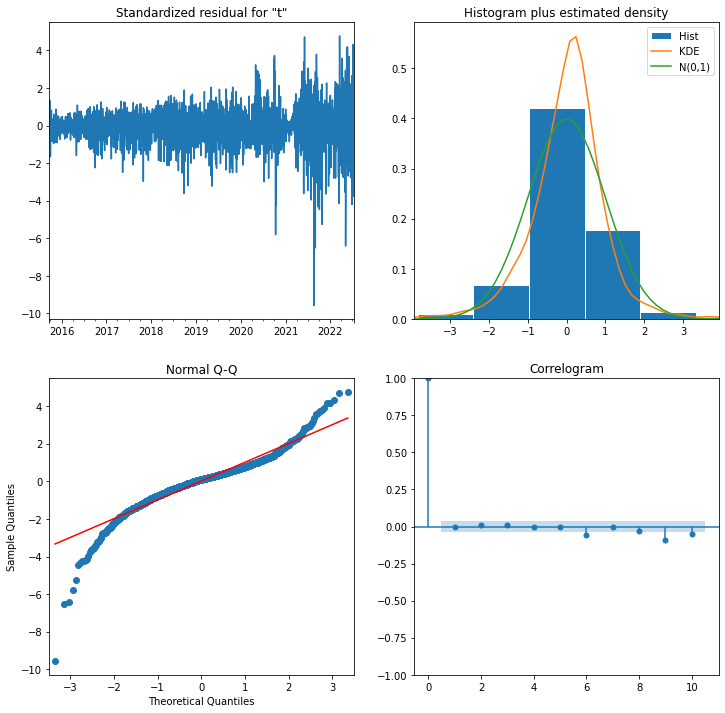

In [114]:
# train the model
algorithm = ARIMA(y_train, order=arima_param.get_params()["order"])
model = algorithm.fit()

# check whether the residuals are normally distributed and any correlation
model.plot_diagnostics(figsize=(12, 12))
plt.show()

The error rates of the ARIMA forecasting are: 
MAE = 0.055019 
MSE = 0.083956 
RMSE = 0.007049


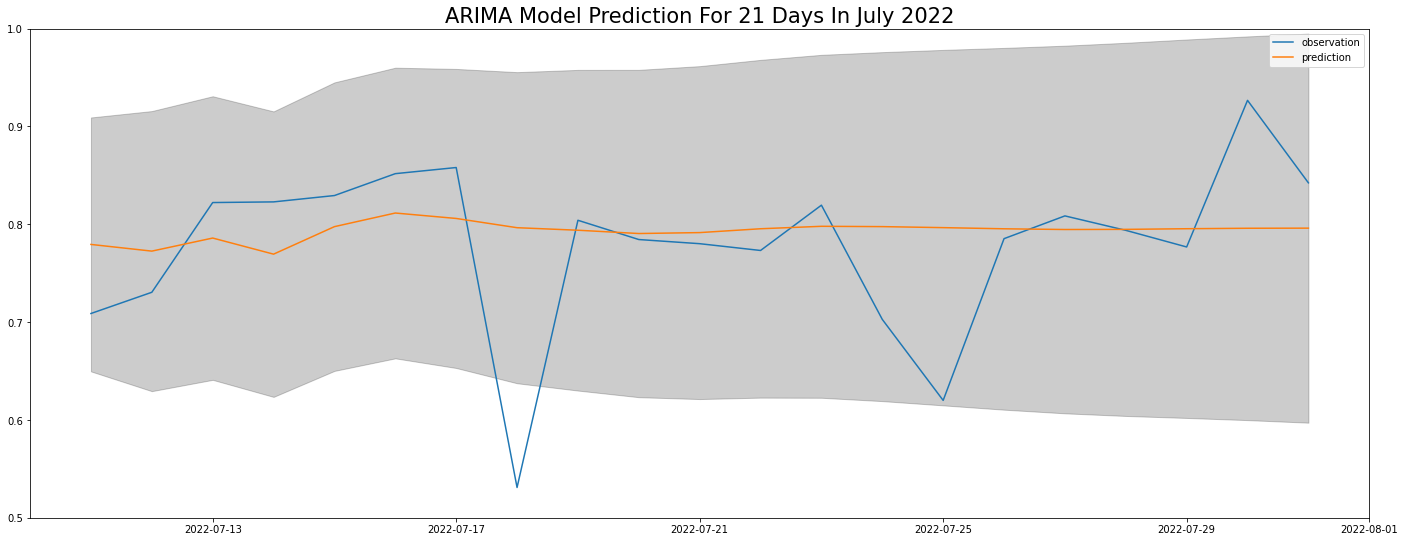

In [116]:
# forecast = model.get_prediction(start=cutoff_date+timedelta(days=1), end=end_date, dynamic=False)
forecast = model.get_forecast(steps=len(y_test), exog=X_test)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the ARIMA forecasting are: \nMAE = %f \nMSE = %f \nRMSE = %f" %(mae, mse, rmse))

plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label = "observation")
plt.plot(prediction.index, prediction,label = "prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([0.5, 1])
plt.title("ARIMA Model Prediction For 21 Days In July 2022", fontsize=21)
plt.legend()
plt.show()

As the result of the ARIMA model, the error rate for predicting July's daily rides is relatively low, but when we look at the chart, we can tell the reason the error rate is low because the prediction is based on the average line of daily rides and omits the randomness in the forecasting.

### *SARIMAX Model*

In [73]:
# m refers to the number of periods in each season. daily-7, weekly-52, monthly-12, quarterly-4, annually-1
sarima_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=1, d=1, start_q=1, start_P=1, D=1, start_Q=1, max_p=5, max_q=5, max_P=5, max_Q=5, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-48314.043, Time=44.14 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-63416.250, Time=1.59 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-44134.799, Time=23.51 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=-50914.680, Time=28.67 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=-45749.637, Time=13.56 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=-49150.390, Time=24.12 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-45263.756, Time=92.28 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-9403.390, Time=47.85 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=-1704.074, Time=52.30 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=-48221.885, Time=24.55 sec
 ARIMA(0,1,0)(0,1,0)[7] intercept   : AIC=-54332.057, Time=4.81 sec

Best model:  ARIMA(0,1,0)(0,1,0)[7]          
Total fit time: 357.518 seconds


In [74]:
# using p values to confirm the residual distribution and the correlation
sarima_param.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 2485
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 7)   Log Likelihood               31713.125
Date:                           Sun, 14 Aug 2022   AIC                         -63416.250
Time:                                   18:10:08   BIC                         -63387.176
Sample:                               09-21-2015   HQIC                        -63405.689
                                    - 07-10-2022                                         
Covariance Type:                             opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
('Morning', 'casual')     0.1333   4.56e-06   2.93e+04      0.000       0.133       0.133
('Morning', 'member')     0.1870   2.81e-06   6.64e+04      0.000       0.187       0.187
('Evening', 'casual')     0.4972   5.27e-06   9.44e+04      0.000       0.497       0.497
('Evening', 'member')     0.3787   3.93e-06   9.64e+04      0.000       0.379       0.379
sigma2                 1.117e-12   4.23e-11      0.026      0.979   -8.18e-11     8.4e-11
===================================================================================
Ljung-Box (L1) (Q):                 273.75   Jarque-Bera (JB):              1126.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.80   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


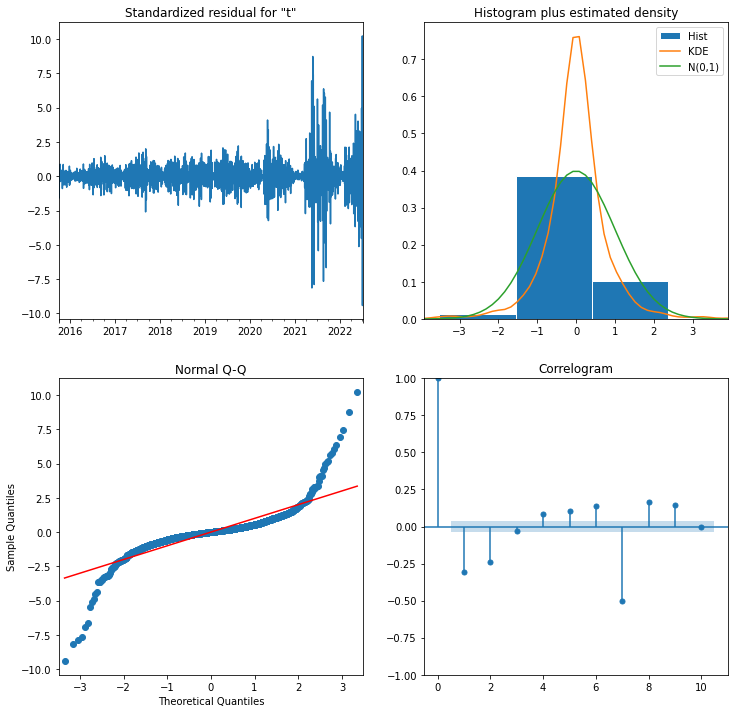

In [135]:
# train the model with the member riders as the external factor
algorithm = SARIMAX(endog=y_train, exog=X_train[X_train.columns[[1, 3]]], order=sarima_param.get_params()["order"], seasonal_order=sarima_param.get_params()["seasonal_order"])
model = algorithm.fit(disp=False)

# check whether the residuals are normally distributed and any correlation
model.plot_diagnostics(figsize=(12, 12))
plt.show()

The error rates of the SARIMA forecasting are: 
MAE = 0.157664 
MSE = 0.206488 
RMSE = 0.042637


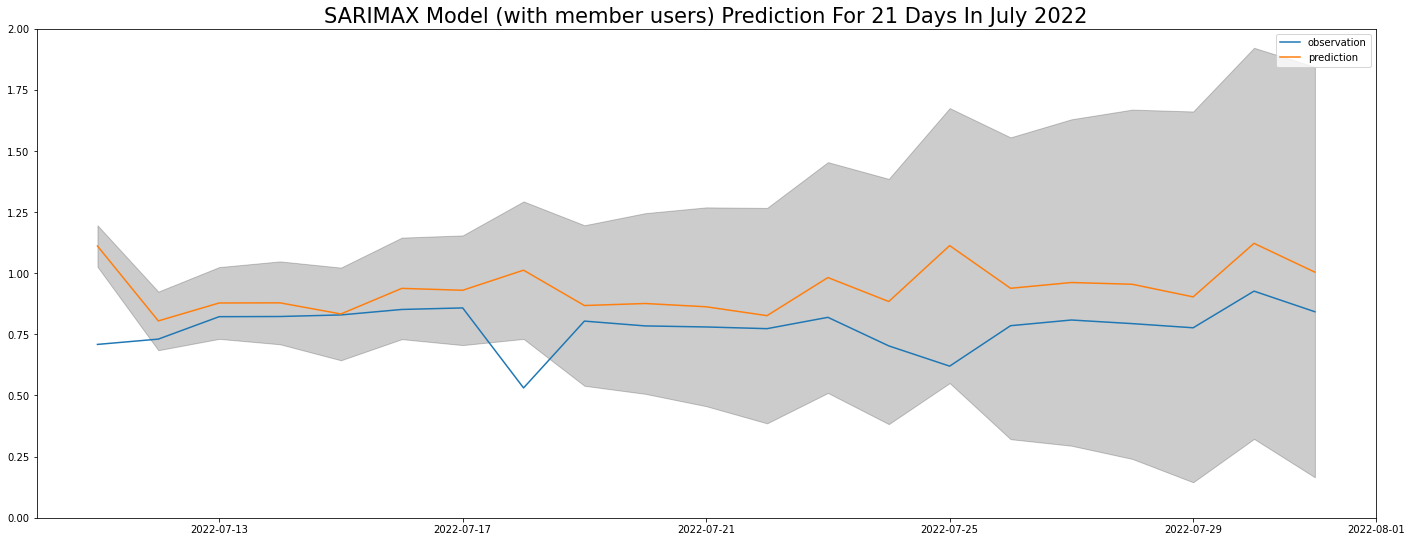

In [136]:
forecast = model.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test[X_test.columns[[1, 3]]], dynamic=True)
# forecast = model.get_forecast(steps=len(test), exog=test.index.values.astype("float64"))
prediction = forecast.predicted_mean
ci = forecast.conf_int()

mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the SARIMA forecasting are: \nMAE = %f \nMSE = %f \nRMSE = %f" %(mae, mse, rmse))

plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label = "observation")
plt.plot(prediction.index, prediction, label = "prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([0, 2])
plt.title("SARIMAX Model (with member users) Prediction For 21 Days In July 2022", fontsize=21)
plt.legend()
plt.show()

C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\naerkond\Programming_Languages\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


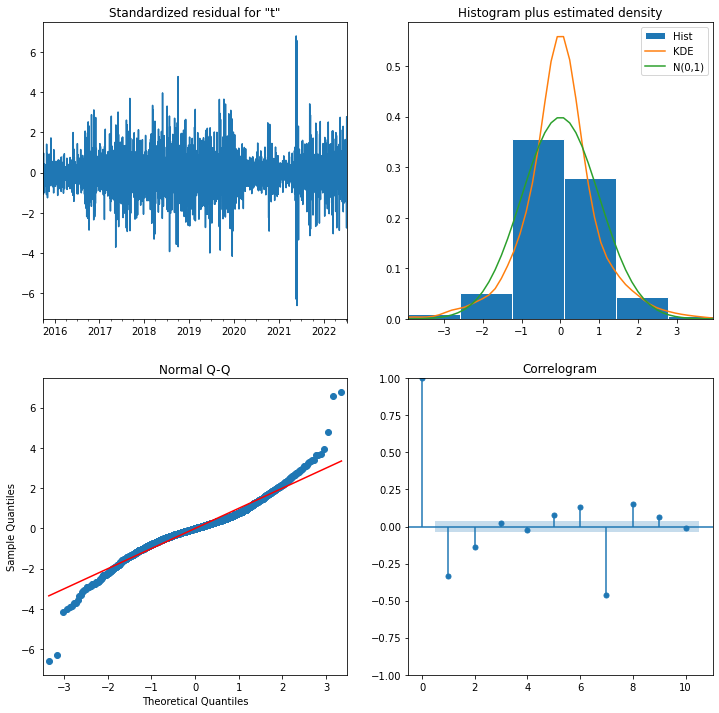

In [146]:
# train the model with the causal riders as the external factor
algorithm = SARIMAX(endog=y_train, exog=X_train[X_train.columns[[0, 2]]], order=sarima_param.get_params()["order"], seasonal_order=sarima_param.get_params()["seasonal_order"])
model = algorithm.fit(disp=False)

# check whether the residuals are normally distributed and any correlation
model.plot_diagnostics(figsize=(12, 12))
plt.show()

The error rates of the SARIMA forecasting are: 
MAE = 0.076175 
MSE = 0.092300 
RMSE = 0.008519


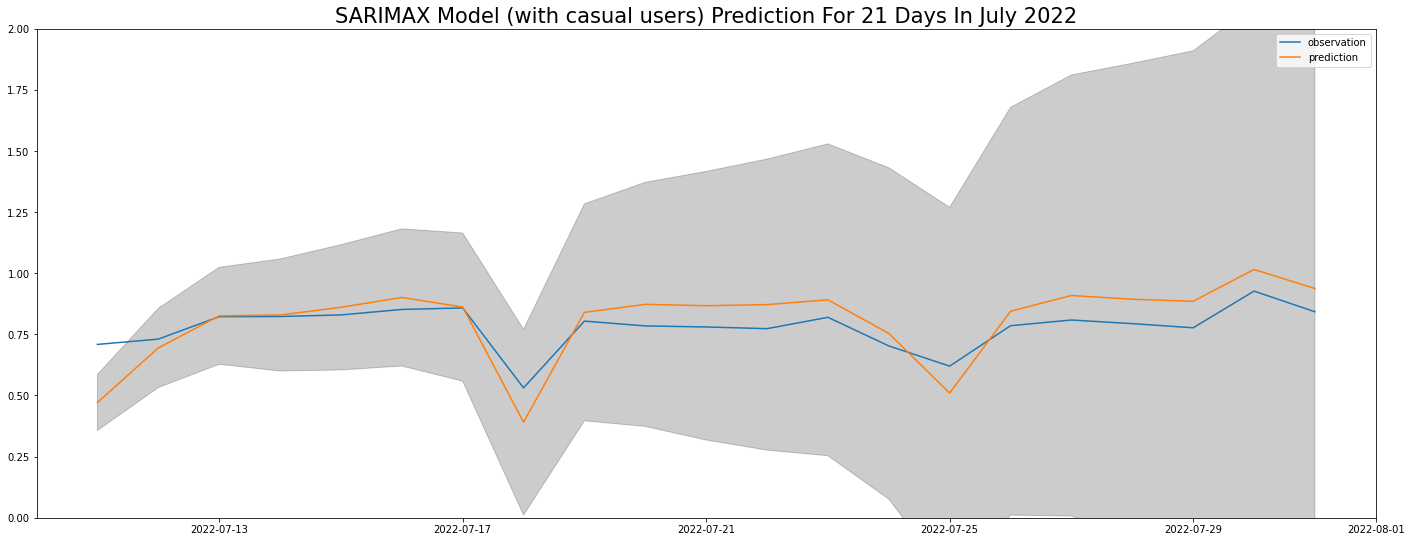

In [147]:
forecast = model.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test[X_test.columns[[0, 2]]], dynamic=True)
# forecast = model.get_forecast(steps=len(test), exog=test.index.values.astype("float64"))
prediction = forecast.predicted_mean
ci = forecast.conf_int()

mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the SARIMA forecasting are: \nMAE = %f \nMSE = %f \nRMSE = %f" %(mae, mse, rmse))

plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label = "observation")
plt.plot(prediction.index, prediction, label = "prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([0, 2])
plt.title("SARIMAX Model (with casual users) Prediction For 21 Days In July 2022", fontsize=21)
plt.legend()
plt.show()

In the SARIMAX model, we not only include the seasonality of the model but also discover that "casual" users' data as an external factor has a more positive impact than "member" users' data. When we use "member" users' data to train the model, the error rates of July's daily rides will significantly increase, and we can see the prediction is always greater than the test data in the plot. Yet, when we use "casual" users' data to train the model, the error rate for predicting July's daily rides will be much lower. We can tell the error rate is low because the prediction almost perfectly catches the randomness of daily usage in the forecasting.

### *TBATS model*

*For more information: https://medium.com/analytics-vidhya/time-series-forecasting-using-tbats-model-ce8c429442a9*

In [122]:
algorithm = TBATS(seasonal_periods=(7, 365.25))
model = algorithm.fit(y_train)

The error rates of the TBATS forecasting are: 
MAE = 0.071640 
MSE = 0.094942 
RMSE = 0.009014


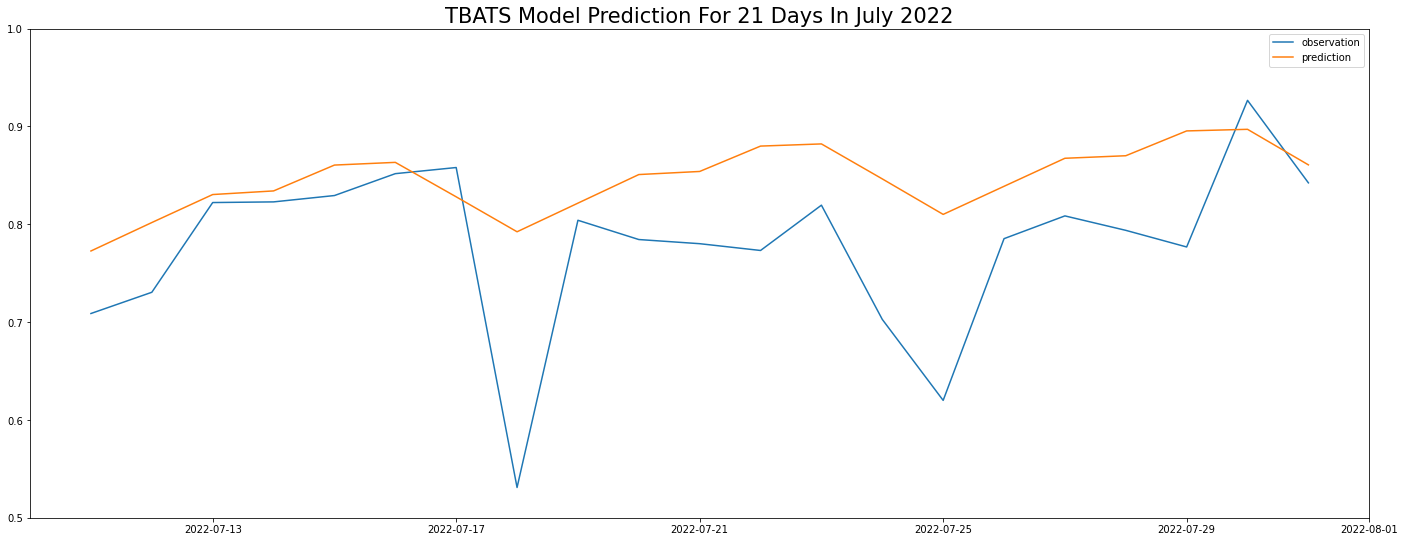

In [123]:
prediction = pd.DataFrame({"prediction": model.forecast(steps=len(y_test)).T}, index=y_test.index)

mae = mean_absolute_error(y_test, prediction)
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the TBATS forecasting are: \nMAE = %f \nMSE = %f \nRMSE = %f" %(mae, mse, rmse))

plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test,label = "observation")
plt.plot(prediction.index, prediction,label = "prediction")
plt.ylim([0.5, 1])
plt.title("TBATS Model Prediction For 21 Days In July 2022", fontsize=21)
plt.legend()
plt.show()

As the result of the TBATS model, the error rate for predicting July’s daily rides is a little higher than ARIMA and SARIMAX models, but when we look at the chart, we can tell the model is not just simply predicting based on the average line of daily rides, but also catch certain level of randomnesses in the forecasting.

# Discussion
At the beginning of the project, we did not fully understand the limitations of the time series model and set the lags (prediction dates) to a number that would cause our prediction converges to the mean, which will become a line and useless. It is the main reason we decide only to predict 21 days in July's daily rides to prevent unreliable forecasting.
In the future, we plan to train the models with each station's daily usage with a better way to fill the missing data value and add weather as an external factor. Moreover, we will also implement Azure AutoML on the dataset to try different algorithms.

# Conclusion

One of the exciting insights we discovered is that causal users' data is a solid external factor to assist us in predicting daily bike usage, but at the same time, casual users only take 22.6% of the entire dataset. It is possibly related to another insight we mentioned earlier that members and casual users have different reasons to use the share bike. Most member users have fixed routes since they use the share bikes for round trips, which has strong predictability. Yet, those casual users might not have a strong pattern like member users. Therefore, if we can focus more on casual users' daily usage, we can easily catch the randomization to precisely predict everyday rides.
All three time-series models have their pros and cons. Therefore, it's not appropriate to adjust which model is useless when we try to predict the future. For the stakeholders looking for stable prediction results, I will recommend using ARIMA or TBATS to predict the daily usage to control their inventory amount. However, if the stakeholders are looking for highly precise predictions to plan fast refilling strategies, I recommend using the SARIMAX model.

# Conclusion

One of the exciting insights we discovered is that causal users' data is a solid external factor to assist us in predicting daily bike usage, but at the same time, casual users only take 22.6% of the entire dataset. It is possibly related to another insight we mentioned earlier that members and casual users have different reasons to use the share bike. Most member users have fixed routes since they use the share bikes for round trips, which has strong predictability. Yet, those casual users might not have a strong pattern like member users. Therefore, if we can focus more on casual users' daily usage, we can easily catch the randomization to precisely predict everyday rides.
All three time-series models have their pros and cons. Therefore, it's not appropriate to adjust which model is useless when we try to predict the future. For the stakeholders looking for stable prediction results, I will recommend using ARIMA or TBATS to predict the daily usage to control their inventory amount. However, if the stakeholders are looking for highly precise predictions to plan fast refilling strategies, I recommend using the SARIMAX model.

# Conclusion

One of the exciting insights we discovered is that causal users' data is a solid external factor to assist us in predicting daily bike usage, but at the same time, casual users only take 22.6% of the entire dataset. It is possibly related to another insight we mentioned earlier that members and casual users have different reasons to use the share bike. Most member users have fixed routes since they use the share bikes for round trips, which has strong predictability. Yet, those casual users might not have a strong pattern like member users. Therefore, if we can focus more on casual users' daily usage, we can easily catch the randomization to precisely predict everyday rides.
All three time-series models have their pros and cons. Therefore, it's not appropriate to adjust which model is useless when we try to predict the future. For the stakeholders looking for stable prediction results, I will recommend using ARIMA or TBATS to predict the daily usage to control their inventory amount. However, if the stakeholders are looking for highly precise predictions to plan fast refilling strategies, I recommend using the SARIMAX model.